In [1]:
from MonteCarlo import RandomNumberGenerator, GeometricBrownianMotion


In [17]:
gbm = GeometricBrownianMotion(r=0.1, d=0.1, T = 10, vol = 0.3, dt = 0.001, S_0 = 1)
gbm.simulate_paths(n=10)
gbm.final_values(n=10)

array([0.65831227, 0.57371609, 0.12041358, 0.56018875, 0.24002698,
       0.71942297, 1.84928008, 2.504021  , 0.83024888, 0.28155686])

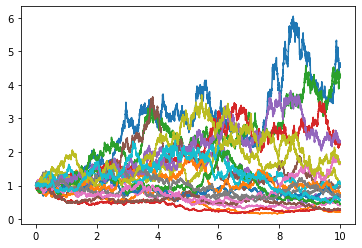

In [18]:
gbm.plot_paths(n=20)